In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5648457414020920932
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15134713447
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18287975853137320311
physical_device_desc: "device: 0, name: Quadro RTX 5000, pci bus id: 0000:65:00.0, compute capability: 7.5"
]


In [2]:
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [4]:
train_df = pd.read_csv('./train.csv')

# 데이터 노이즈 수정
train_df.loc[train_df['id'] == 3896, 'artist'] = 'Titian'
train_df.loc[train_df['id'] == 3986, 'artist'] = 'Alfred Sisley'

label_encoder = LabelEncoder()
train_df['artist'] = label_encoder.fit_transform(train_df['artist'].values)
x_train, x_val, y_train, y_val = train_test_split(train_df['img_path'], train_df['artist'].values, test_size=0.2)

one_hot_encoder = OneHotEncoder(sparse=False)
y_train = one_hot_encoder.fit_transform(y_train.reshape(-1, 1))
y_val = one_hot_encoder.transform(y_val.reshape(-1, 1))

print("shape of x_train:", x_train.shape)
print("shape of x_val:", x_val.shape)
print("shape of y_train:", y_train.shape)
print("shape of y_val:", y_val.shape)

shape of x_train: (4728,)
shape of x_val: (1183,)
shape of y_train: (4728, 50)
shape of y_val: (1183, 50)


In [7]:
def image_crop_load(image_path):
    # Load your own image
    image = cv2.imread(image_path)

    # Crop the center of the image to a square size
    cropped_image = image[((image.shape[0] - min(image.shape[:2])) // 2):((image.shape[0] + min(image.shape[:2])) // 2),
                          ((image.shape[1] - min(image.shape[:2])) // 2):((image.shape[1] + min(image.shape[:2])) // 2)]

    # Resize the image to the desired input size
    resized_image = cv2.resize(cropped_image, (244, 244))

    # Return the preprocessed image
    return resized_image / 255.0

def image_load(image_path):
    image = cv2.imread(image_path)
    resized_image = cv2.resize(image, (244, 244))
    return resized_image / 255.0

In [8]:
x_train_list, x_val_list = [], []

for img_path in x_train:
    x_train_list.append(image_load(img_path))

x_train = np.array(x_train_list)

for img_path in x_val:
    x_val_list.append(image_load(img_path))

x_val = np.array(x_val_list)

In [13]:
# ResNet50 모델 로드
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(244, 244, 3), pooling=None, input_tensor=None)

# 새로운 Fully Connected Layer 추가
x = base_model.output
x = Flatten()(x)
x = Dropout(0.2)(x) # 드롭아웃 추가
predictions = Dense(50, activation='softmax')(x)

#전체 모델 구성
model = Model(inputs=base_model.input, outputs=predictions)


# 모델 컴파일
model.compile(optimizer=Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
from tensorflow.keras.callbacks import EarlyStopping

# Early Stopping 콜백
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [15]:
# 모델 학습
history = model.fit(x_train, y_train,
                    batch_size=32,
                    epochs=50,
                    validation_data=(x_val, y_val),
                    callbacks=([early_stopping])
)

Train on 4728 samples, validate on 1183 samples
Epoch 1/50
4728/4728 [==============================] - 48s 10ms/sample - loss: 4.3710 - accuracy: 0.2109 - val_loss: 4.7437 - val_accuracy: 0.0127
Epoch 2/50
4728/4728 [==============================] - 39s 8ms/sample - loss: 2.4752 - accuracy: 0.3555 - val_loss: 4.1312 - val_accuracy: 0.0127
Epoch 3/50
4728/4728 [==============================] - 39s 8ms/sample - loss: 2.0185 - accuracy: 0.4535 - val_loss: 6.6663 - val_accuracy: 0.0110
Epoch 4/50
4728/4728 [==============================] - 39s 8ms/sample - loss: 1.6408 - accuracy: 0.5457 - val_loss: 6.9918 - val_accuracy: 0.0101
Epoch 5/50
4728/4728 [==============================] - 39s 8ms/sample - loss: 1.1205 - accuracy: 0.6753 - val_loss: 9.6312 - val_accuracy: 0.0719
Epoch 00005: early stopping


In [17]:
score = model.evaluate(x_val, y_val, verbose=0)
print('val_loss:', round(score[0], 6))
print(f'val_accuracy: {round(score[1] * 100, 3)}%')

val_loss: 9.631177
val_accuracy: 7.185%


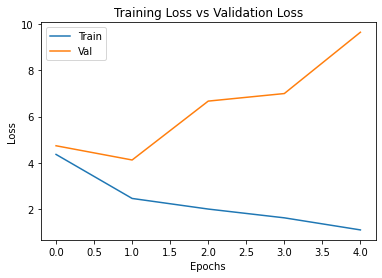

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train','Val'])
plt.show()

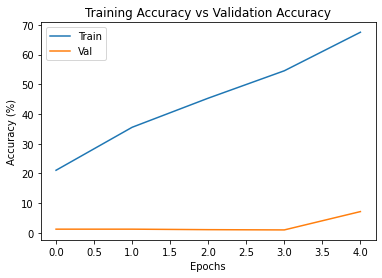

In [19]:
plt.plot([x * 100 for x in history.history['accuracy']])
plt.plot([x * 100 for x in history.history['val_accuracy']])
plt.title('Training Accuracy vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train', 'Val'])
plt.show()